In [90]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import scipy.misc
from skimage.transform import resize

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams.update({'font.size': 14})
                    
                    
# Load Cylinder flow data set
mat_contents = scipy.io.loadmat(os.path.join('CYLINDER_ALL'))
vortall=mat_contents['VORTALL']

m, n = np.shape(vortall) 

print("number of datapoints:", m)
print("number of snapshots:", n)

number of datapoints: 89351
number of snapshots: 151


In [91]:
# Coarsen by a factor of 20 in each direction using imresize 
nvortall=np.copy(np.real(np.reshape(vortall[:,0],(449,199))))
dim = (np.array(nvortall.shape) * (1/20)).astype(int)
dim_tot=dim[0]*dim[1]
print(dim_tot)

198


In [92]:
# Build a library of these coarsened measurements
library = np.empty((dim_tot,n))
for i in range(n):
    temp = np.copy(np.real(np.reshape(vortall[:,i],(449,199))))
    temp_low = resize(temp, dim, anti_aliasing=True) 
    library[:,i] = np.reshape(temp_low,dim_tot)

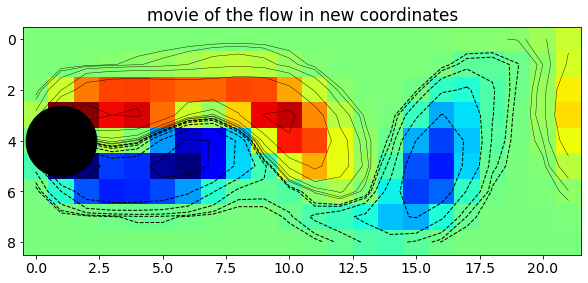

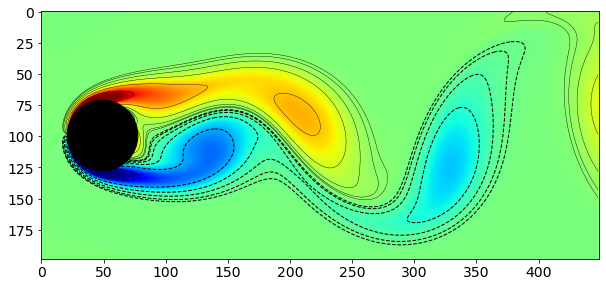

In [93]:
# Plot a movie of the flow field in these new coordinates
# From CH7 - 7.2

def EigenflowField(vortall):
    vortmin = -5
    vortmax = 5
    V2 = np.copy(np.real(np.reshape(vortall,(22,9))))
    V2 = V2.T

    # normalize values... not symmetric
    minval = np.min(V2)
    maxval = np.max(V2)

    if np.abs(minval) < 5 and np.abs(maxval) < 5:
        if np.abs(minval) > np.abs(maxval):
            vortmax = maxval
            vortmin = -maxval
        else:
            vortmin = minval
            vortmax = -minval

    V2[V2 > vortmax] = vortmax
    V2[V2 < vortmin] = vortmin

    plt.figure(1)
    plt.imshow(V2,cmap='jet',vmin=vortmin,vmax=vortmax)

    cvals = np.array([-4,-2,-1,-0.5,-0.25,-0.155])
    plt.contour(V2,cvals*vortmax/5,colors='k',linestyles='dashed',linewidths=1)
    plt.contour(V2,np.flip(-cvals)*vortmax/5,colors='k',linestyles='solid',linewidths=0.4)
    plt.scatter(1,4,5000,color='k') # draw cylinder
    plt.show()

    
def EigenflowField_vort(vortall):
    vortmin = -5
    vortmax = 5
    V2 = np.copy(np.real(np.reshape(vortall,(449,199))))
    V2 = V2.T

    # normalize values... not symmetric
    minval = np.min(V2)
    maxval = np.max(V2)

    if np.abs(minval) < 5 and np.abs(maxval) < 5:
        if np.abs(minval) > np.abs(maxval):
            vortmax = maxval
            vortmin = -maxval
        else:
            vortmin = minval
            vortmax = -minval

    V2[V2 > vortmax] = vortmax
    V2[V2 < vortmin] = vortmin

    plt.figure(1)
    plt.imshow(V2,cmap='jet',vmin=vortmin,vmax=vortmax)

    cvals = np.array([-4,-2,-1,-0.5,-0.25,-0.155])
    plt.contour(V2,cvals*vortmax/5,colors='k',linestyles='dashed',linewidths=1)
    plt.contour(V2,np.flip(-cvals)*vortmax/5,colors='k',linestyles='solid',linewidths=0.4)
    plt.scatter(49,99,5000,color='k') # draw cylinder
    plt.show()
    
    
plt.title('movie of the flow in new coordinates')
EigenflowField(library[:,8])


plt.show('original movie of the flow')
EigenflowField_vort(vortall[:,8])

In [94]:
# Pick a column of the full flow field matrix
column_vort = np.copy(vortall[:,8])

#Add Gausian random Noise
vort_noise = np.copy(column_vort) + 0.2*np.random.randn(*nnvort.shape) 

In [95]:
# Downsample noisy field by a factor of 20
dim_new= (np.array(nvortall.shape) * (1/20)).astype(int)
temp_noise = np.reshape(np.copy(vort_noise),(449,199))
temp_noise_low = resize(temp_noise, dim_new, anti_aliasing=True)
vort_new_noise = np.reshape(temp_noise_low, dim_tot)

In [96]:
# Use SRC to find the closest downsampled library element 
## L1 Search
from scipy.optimize import minimize

eps = 0.1
print(np.shape(vort_noise))
# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(library @ x - vort_new_noise,2)})
x0 = np.linalg.pinv(library) @ vort_new_noise # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s1 = res.x

(89351,)
